# Chapter 8: Neural Networks
## Training a Classifier on the *Salammbô* Dataset with PyTorch
We use here the `BCEWithLogitsLoss` for a binary classification. This implementation is more stable than `BCELoss`.

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Modules

We first need to import some modules

In [1]:
import torch
import torch.nn as nn
import numpy as np

We set seeds to have reproducible results

In [2]:
np.random.seed(1337)
torch.manual_seed(4321)

### Reading the dataset
We can read the data from a file with the svmlight format or directly create numpy arrays

In [3]:
X = np.array(
    [[35680, 2217], [42514, 2761], [15162, 990], [35298, 2274],
     [29800, 1865], [40255, 2606], [74532, 4805], [37464, 2396],
     [31030, 1993], [24843, 1627], [36172, 2375], [39552, 2560],
     [72545, 4597], [75352, 4871], [18031, 1119], [36961, 2503],
     [43621, 2992], [15694, 1042], [36231, 2487], [29945, 2014],
     [40588, 2805], [75255, 5062], [37709, 2643], [30899, 2126],
     [25486, 1784], [37497, 2641], [40398, 2766], [74105, 5047],
     [76725, 5312], [18317, 1215]
     ])

y = np.array(
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Scaling the Data
Scaling and normalizing are usually very significant with neural networks. We use sklean transformers. They consist of two main methods: `fit()` and `transform()`.

### Normalizing

In [4]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
X_norm = normalizer.fit_transform(X)
X_norm[:4]

array([[0.99807515, 0.06201605],
       [0.99789783, 0.06480679],
       [0.99787509, 0.06515607],
       [0.99793128, 0.06428964]])

### Standardizing

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X_norm)
X_scaled[:4]

array([[ 1.68336574, -1.7197772 ],
       [ 0.57376529, -0.56145427],
       [ 0.43143908, -0.41648279],
       [ 0.78308579, -0.77610221]])

## Creating PyTorch Tensors
PyTorch has its own implementation of matrices called tensors. They are more or less equivalent to NumPy arrays. We need to convert our dataset to these tensors and represent $\mathbf{y}$  as a column vector

In [6]:
Y = y.reshape((-1, 1))
Y[:4]

array([[0],
       [0],
       [0],
       [0]])

In [7]:
X_scaled = torch.from_numpy(X_scaled).float()
X_scaled

tensor([[ 1.6834, -1.7198],
        [ 0.5738, -0.5615],
        [ 0.4314, -0.4165],
        [ 0.7831, -0.7761],
        [ 1.5095, -1.5348],
        [ 0.6568, -0.6464],
        [ 0.7646, -0.7571],
        [ 0.9700, -0.9692],
        [ 0.8610, -0.8564],
        [ 0.3516, -0.3355],
        [ 0.2834, -0.2665],
        [ 0.6618, -0.6515],
        [ 1.2025, -1.2115],
        [ 0.6947, -0.6852],
        [ 1.7127, -1.7511],
        [-0.5712,  0.5835],
        [-0.9400,  0.9424],
        [-0.0189,  0.0371],
        [-0.9622,  0.9639],
        [-0.3768,  0.3925],
        [-1.1617,  1.1560],
        [-0.3802,  0.3957],
        [-1.5856,  1.5599],
        [-1.0314,  1.0306],
        [-1.5463,  1.5228],
        [-1.7352,  1.7012],
        [-0.8880,  0.8921],
        [-0.7341,  0.7426],
        [-1.2155,  1.2076],
        [ 0.0071,  0.0112]])

In [8]:
Y = torch.from_numpy(Y).float()
Y[:4]

tensor([[0.],
        [0.],
        [0.],
        [0.]])

## Creating a Model: `Sequential`

In [9]:
from collections import OrderedDict

simple = True
if simple:
    model = nn.Sequential(
        nn.Linear(2, 1)
    )
else:
    model = nn.Sequential(OrderedDict([
        ('W1', nn.Linear(2, 5)),  # W1x + b1
        ('reLU', nn.ReLU()),       # reLU(W1x + b1)
        ('W2', nn.Linear(5, 1))   # W2reLU(W1x + b1) + b2
    ]))

In [10]:
loss_fn = nn.BCEWithLogitsLoss()    # binary cross entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
model = torch.compile(model)

### Batch Gradient Descent

We fit the whole dataset (batch gradient descent)

In [12]:
model.train()               # sets PyTorch in the train mode
bce_loss = []
for epoch in range(30):
    Y_pred = model(X_scaled)
    loss = loss_fn(Y_pred, Y)
    bce_loss += [loss.item()]
    optimizer.zero_grad()   # resets the gradients
    loss.backward()         # gradient backpropagation
    optimizer.step()        # weight updates

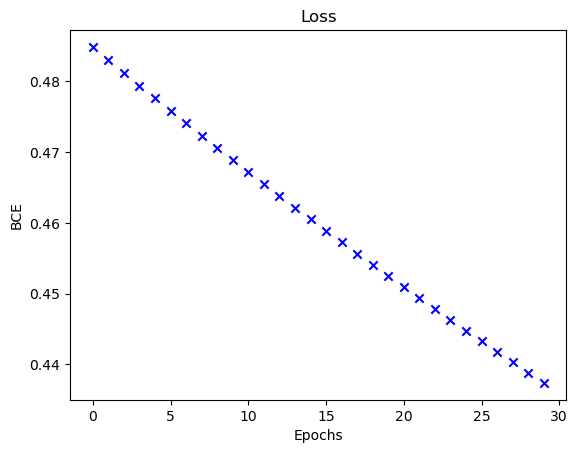

In [13]:
import matplotlib.pyplot as plt

plt.scatter(range(len(bce_loss)),
            bce_loss, c='b', marker='x')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE')
plt.show()

In [14]:
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_scaled)
    y_pred_proba = torch.sigmoid(y_pred_logits)
y_pred_proba

tensor([[0.2562],
        [0.4444],
        [0.4710],
        [0.4057],
        [0.2823],
        [0.4289],
        [0.4090],
        [0.3720],
        [0.3915],
        [0.4861],
        [0.4989],
        [0.4280],
        [0.3318],
        [0.4219],
        [0.2520],
        [0.6544],
        [0.7140],
        [0.5557],
        [0.7174],
        [0.6207],
        [0.7466],
        [0.6213],
        [0.8017],
        [0.7278],
        [0.7970],
        [0.8189],
        [0.7060],
        [0.6815],
        [0.7542],
        [0.5508]])

### Classes

In [15]:
def predict_class(y_pred_proba):
    y_pred = torch.zeros(y_pred_proba.size(dim=0))
    for i in range(y_pred_proba.size(dim=0)):
        if y_pred_proba[i][0] >= 0.5:
            y_pred[i] = 1
    return y_pred

In [16]:
y_pred = predict_class(y_pred_proba)
y_pred

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## The weights

In [17]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.6147,  0.1383]], requires_grad=True),
 Parameter containing:
 tensor([0.2068], requires_grad=True)]

Also in the form of a dictionary

In [18]:
model.state_dict()

OrderedDict([('_orig_mod.0.weight', tensor([[-0.6147,  0.1383]])),
             ('_orig_mod.0.bias', tensor([0.2068]))])

## Checking the Model
We recompute it with matrices

In [19]:
m_params = list(model.parameters())

In [20]:
if simple:
    print(torch.sigmoid(X_scaled @ m_params[0].T + m_params[1])[:4])
else:
    print(torch.sigmoid(torch.relu(
        X_scaled @ m_params[0].T + m_params[1]) @ m_params[2].T + m_params[3])[:4])

tensor([[0.2562],
        [0.4444],
        [0.4710],
        [0.4057]], grad_fn=<SliceBackward0>)


## Fitting the Model
In addition to batch gradient descent, we will see stochastic descent and minibatches

### Stochastic Gradient Descent

or, we fit the model with a batch size of one item (stochastic gradient descent)

In [21]:
model.train()
for epoch in range(30):
    for x_scaled, y in zip(X_scaled, Y):
        y_pred = model(x_scaled)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Minibatch Gradient Descent

Or we fit it with mini-batches, first with a simple inner loop

In [22]:
BATCH_SIZE = 4
model.train()
for epoch in range(30):
    # Would need to shuffle X and y
    for i in range(0, X_scaled.size(dim=0), BATCH_SIZE):
        Y_batch_pred = model(X_scaled[i:i + BATCH_SIZE])
        loss = loss_fn(Y_batch_pred, Y[i:i + BATCH_SIZE])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Then with a dataloader

In [23]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_scaled, Y)
dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

In [24]:
model.train()
for epoch in range(30):
    for X_scaled_batch, Y_batch in dataloader:
        Y_batch_pred = model(X_scaled_batch)
        loss = loss_fn(Y_batch_pred, Y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [25]:
model.eval()
with torch.no_grad():
    y_pred = torch.sigmoid(model(X_scaled))
    print(predict_class(y_pred))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


## Creating a Model with by Subclassing `Module`

We define a classifier equivalent to a logistic regression

In [26]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc1(x)

And a model with one hidden layer

In [27]:
class Model2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

We create the model. To try the network with one hidden layer, set `complex` to true

In [28]:
simple = False

In [29]:
input_dim = X_scaled.size(dim=1)
input_dim

2

In [30]:
if simple:
    model = Model(input_dim)
else:
    model = Model2(input_dim)
model

Model2(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

In [31]:
loss_fn = nn.BCEWithLogitsLoss()    # binary cross entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [32]:
model = torch.compile(model)

## Fitting the Model
We will show three methods: batch gradient descent, stochastic descent, and minibatches

### Batch Gradient Descent

We fit the whole dataset (batch gradient descent)

In [33]:
model.train()               # sets PyTorch in the train mode
bce_loss = []
for epoch in range(30):
    Y_pred = model(X_scaled)
    loss = loss_fn(Y_pred, Y)
    bce_loss += [loss.item()]
    optimizer.zero_grad()   # resets the gradients
    loss.backward()         # gradient backpropagation
    optimizer.step()        # weight updates

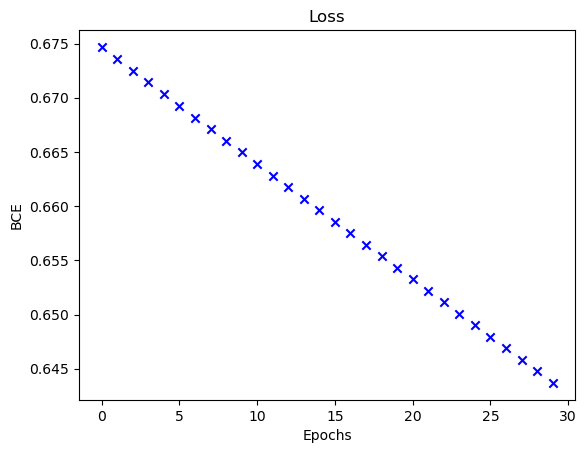

In [34]:
import matplotlib.pyplot as plt

plt.scatter(range(len(bce_loss)),
            bce_loss, c='b', marker='x')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE')
plt.show()

### Stochastic Gradient Descent

or, we fit the model with a batch size of one item (stochastic gradient descent)

In [35]:
model.train()
for epoch in range(30):
    for x_scaled, y in zip(X_scaled, Y):
        y_pred = model(x_scaled)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Minibatch Gradient Descent

Or we fit it with mini-batches, first with a simple inner loop

In [36]:
model.train()
for epoch in range(30):
    # Would need to shuffle X and y
    for i in range(0, X_scaled.size(dim=0), BATCH_SIZE):
        Y_batch_pred = model(X_scaled[i:i + BATCH_SIZE])
        loss = loss_fn(Y_batch_pred, Y[i:i + BATCH_SIZE])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Then with a dataloader

In [37]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_scaled, Y)
dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

In [38]:
model.train()
for epoch in range(30):
    for X_scaled_batch, Y_batch in dataloader:
        Y_batch_pred = model(X_scaled_batch)
        loss = loss_fn(Y_batch_pred, Y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

## Prediction

### Probabilities

We compute the probabilities to belong to class 1 for all the training set

In [39]:
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_scaled)
    y_pred_proba = torch.sigmoid(y_pred_logits)
y_pred_proba[:4]

tensor([[0.0177],
        [0.0805],
        [0.1489],
        [0.0613]])

We recompute it with matrices

In [40]:
m_params = list(model.parameters())

In [41]:
with torch.no_grad():
    if simple:
        print(torch.sigmoid(X_scaled @ m_params[0].T + m_params[1])[:4])
    else:
        print(torch.sigmoid(torch.relu(
            X_scaled @ m_params[0].T + m_params[1]) @ m_params[2].T + m_params[3])[:4])

tensor([[0.0177],
        [0.0805],
        [0.1489],
        [0.0613]])


## Evaluation

In [42]:
predict_class(y_pred_proba)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [43]:
from sklearn.metrics import classification_report
with torch.no_grad():
    print(classification_report(Y, predict_class(y_pred_proba)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



We computed the accuracy from the training set. This is not a good practice. We should use a dedicated test set instead.